In [16]:
import gensim.downloader as api
import numpy as np
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import ast
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Word Embeddings (FastText for Kyrgyz)

In [17]:
embedding_path = "/kaggle/input/project-files/cc.ky.300.vec"
fasttext_model = KeyedVectors.load_word2vec_format(embedding_path)
# Check the number of words and vector size
print(f"Vocabulary size: {len(fasttext_model.key_to_index)}")
print(f"Vector dimension: {fasttext_model.vector_size}")

# Example word
print(fasttext_model['көмүр'][:10])  # first 10 values of embedding

Vocabulary size: 747995
Vector dimension: 300
[-0.0275 -0.0695  0.0416  0.0121 -0.0025  0.0585  0.0285  0.05    0.0057
  0.0773]


### Tokenization & Padding

In [18]:
# Load the cleaned and stemmed dataset
filtered_df = pd.read_csv("/kaggle/input/project-files/filtered_df_stemmed.csv")

# Confirm it loaded correctly
print(filtered_df.shape)
filtered_df.head()

(4437, 7)


,text,label,source,text_clean,tokens,tokens_stemmed,label_encoded
0,"Электр жетишсиз, көмүр кымбат - өкмөт келсин",negative,post,электр жетишсиз көмүр кымбат өкмөт келсин,"['электр', 'жетишсиз', 'көмүр', 'кымбат', 'өкм...","['электр', 'жетишсиз', 'көмүр', 'кымбат', 'өкм...",0
1,ТҮШТҮКТӨ КӨМҮРДҮН ТОННАСЫ 7 МИҢ СОМГО ЧЫКТЫ,negative,post,түштүктө көмүрдүн тоннасы 7 миң сомго чыкты,"['түштүктө', 'көмүрдүн', 'тоннасы', '7', 'миң'...","['түштүктө', 'көмүр', 'тоннасы', '7', 'миң', '...",0
2,Кызыл-Кыя шаарындагы цемент заводунун жанында ...,negative,post,кызылкыя шаарындагы цемент заводунун жанында с...,"['кызылкыя', 'шаарындагы', 'цемент', 'заводуну...","['кызылкыя', 'шаарын', 'цемент', 'заводу', 'жа...",0
3,Кызыл-Кыя шаарындагы цемент заводунун жанында ...,negative,post,кызылкыя шаарындагы цемент заводунун жанында с...,"['кызылкыя', 'шаарындагы', 'цемент', 'заводуну...","['кызылкыя', 'шаарын', 'цемент', 'заводу', 'жа...",0
4,Кыргызстан.Соңку бир апта ичинде Кыргызстанда ...,negative,post,кыргызстансоңку апта ичинде кыргызстанда сүт э...,"['кыргызстансоңку', 'апта', 'ичинде', 'кыргызс...","['кыргызстансоңку', 'апта', 'ичин', 'кыргызста...",0


In [19]:
# Convert stringified list to actual list (if needed)
filtered_df['tokens_stemmed'] = filtered_df['tokens_stemmed'].apply(ast.literal_eval)

# Join tokens back into a space-separated string
filtered_df['text_stemmed'] = filtered_df['tokens_stemmed'].apply(lambda tokens: ' '.join(tokens))

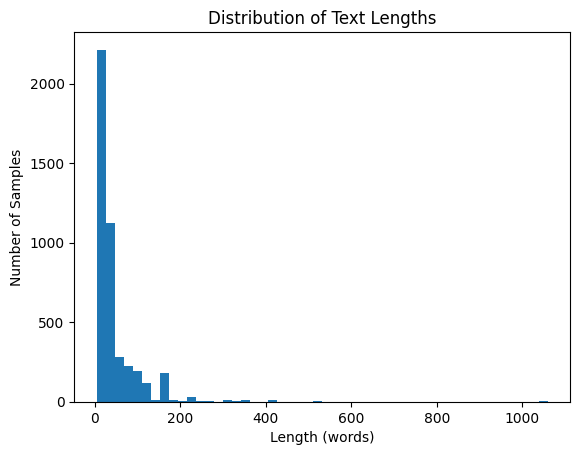

Vocabulary size: 7011
Max sequence length: 250
X_train_seq shape: (3549, 250)
X_test_seq shape: (888, 250)


In [20]:
# Step 1: Prepare texts and labels
texts = filtered_df['tokens_stemmed'].apply(lambda tokens: ' '.join(tokens)).tolist()
labels = filtered_df['label_encoded'].values

# Step 2: Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

seq_lengths = [len(seq) for seq in sequences]
plt.hist(seq_lengths, bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Length (words)")
plt.ylabel("Number of Samples")
plt.show()

# Step 3: Pad sequences with max length capped at 250
max_seq_len = 250
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post', truncating='post')

# Step 4: Train-test split
X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    padded_sequences, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Optional: check shapes
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Max sequence length: {max_seq_len}")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

### Creating embedding matrix

In [21]:
# Parameters
embedding_dim = 300  # because FastText cc.ky.300.vec uses 300 dimensions

# Initialize the embedding matrix with zeros
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:  # skip if beyond vocab limit
        continue
    if word in fasttext_model:
        embedding_vector = fasttext_model[word]
        embedding_matrix[i] = embedding_vector
    # Else: vector stays as zeros

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (7012, 300)


# LSTM (Long Short-Term Memory)

In [22]:
# Define the LSTM model
max_len = 100
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),  
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 sentiment classes
])
model.build(input_shape=(None, max_len))  # max_len = 250

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746488841.852400    1356 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4900 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746488841.852979    1356 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9018 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 300)            │       2,103,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,331,699 (8.89 MB)

 Trainable params: 2,331,699 (8.89 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
X_train_seq = X_train_seq.astype('float32')
X_test_seq = X_test_seq.astype('float32')

# Train the model
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1 
)

Epoch 1/10


I0000 00:00:1746488846.328225    2346 cuda_dnn.cc:529] Loaded cuDNN version 90300


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5943 - loss: 0.9585 - val_accuracy: 0.5935 - val_loss: 0.9171
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5949 - loss: 0.9198 - val_accuracy: 0.5935 - val_loss: 0.9188
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5949 - loss: 0.9209 - val_accuracy: 0.5935 - val_loss: 0.9171
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5949 - loss: 0.9186 - val_accuracy: 0.5935 - val_loss: 0.9167
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5942 - loss: 0.9153 - val_accuracy: 0.5935 - val_loss: 0.9168
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5948 - loss: 0.9171 - val_accuracy: 0.5935 - val_loss: 0.9190
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5931 - loss: 0.9090 - val_accuracy: 0.5935 - val_loss: 0.9183


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:

              precision    recall  f1-score   support

    Negative       0.59      1.00      0.75       527
     Neutral       0.00      0.00      0.00       100
    Positive       0.00      0.00      0.00       261

    accuracy                           0.59       888
   macro avg       0.20      0.33      0.25       888
weighted avg       0.35      0.59      0.44       888



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


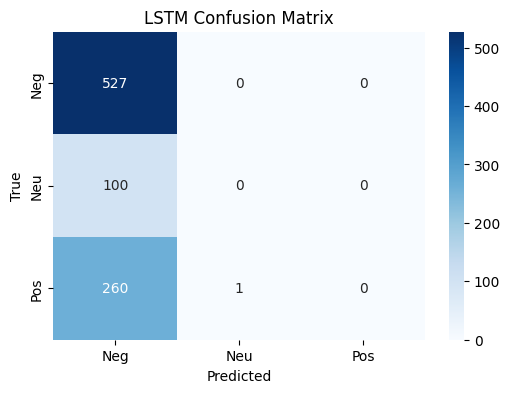

In [24]:
# Predict class probabilities
y_pred_probs = model.predict(X_test_seq)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg','Neu','Pos'], yticklabels=['Neg','Neu','Pos'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()

# 1D CNN

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # For 3 sentiment classes
])

# Compile
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Summary
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,103,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,103,600 (8.02 MB)

 Trainable params: 2,103,600 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

### train the model

In [26]:
history = cnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10


I0000 00:00:1746488874.068864    2343 service.cc:148] XLA service 0x7e9c5c0d4be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746488874.068917    2343 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746488874.068923    2343 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


23/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5678 - loss: 0.9691

I0000 00:00:1746488876.753884    2343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.5847 - loss: 0.9317 - val_accuracy: 0.6757 - val_loss: 0.7640
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6833 - loss: 0.7383 - val_accuracy: 0.7050 - val_loss: 0.6704
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7225 - loss: 0.6685 - val_accuracy: 0.7252 - val_loss: 0.6295
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7421 - loss: 0.6241 - val_accuracy: 0.7500 - val_loss: 0.5969
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7392 - loss: 0.5988 - val_accuracy: 0.7309 - val_loss: 0.5887
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7573 - loss: 0.5746 - val_accuracy: 0.7545 - val_loss: 0.5869
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7526 - loss: 0.5639 - val_accuracy: 0.7466 - val_loss: 0.5834
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7551 - loss: 0.5451 - val_accuracy: 0.7466 - val_loss: 0.5883
Ep

### evaluate CNN

In [27]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = cnn_model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 
              precision    recall  f1-score   support

    Negative       0.78      0.83      0.80       527
     Neutral       0.70      0.45      0.55       100
    Positive       0.66      0.66      0.66       261

    accuracy                           0.74       888
   macro avg       0.71      0.65      0.67       888
weighted avg       0.73      0.74      0.73       888



### visualize CNN training

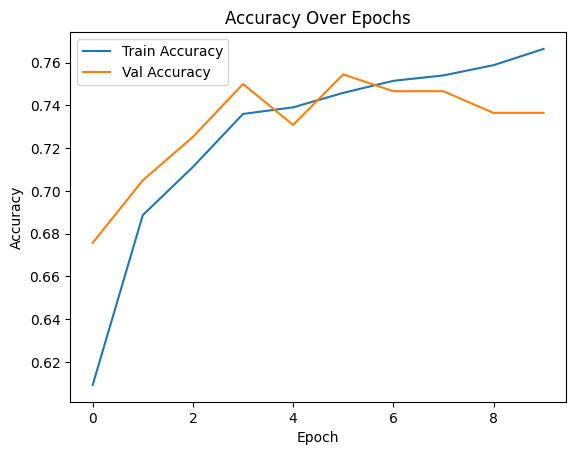

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# XLM-RoBERTa 

In [29]:
# Step 1: Load libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, f1_score

# Step 2: Load your dataset
df = pd.read_csv("/kaggle/input/project-files/filtered_df_stemmed.csv")
df = df[['text_clean', 'label_encoded']]  # change to 'text_stemmed' if you want stemmed version
df = df.rename(columns={'text_clean': 'text', 'label_encoded': 'label'})

# Step 3: Stratified split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Step 4: Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Step 5: Load tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Step 6: Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove old text columns (to avoid error)
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

# Set format for PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")

# Step 7: Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",          # enable eval logging
    save_strategy="epoch",
    logging_strategy="steps",             # log every N steps
    logging_steps=50,                     # show progress every 50 steps
    report_to="none",                     # avoid external integrations like W&B
    disable_tqdm=False                    # ensure progress bar is visible
)

# Step 8: Define evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1_macro": f1_score(p.label_ids, preds, average="macro"),
        "f1_weighted": f1_score(p.label_ids, preds, average="weighted"),
    }

# Step 9: Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 10: Train
trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3549 [00:00<?, ? examples/s]

Map:   0%|          | 0/888 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.939800,0.922923,0.593468,0.248292,0.442061
2,0.924800,0.915286,0.593468,0.248292,0.442061
3,0.910900,0.915984,0.593468,0.248292,0.442061


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=333, training_loss=0.9314421519144878, metrics={'train_runtime': 391.3979, 'train_samples_per_second': 27.202, 'train_steps_per_second': 0.851, 'total_flos': 1400684279275008.0, 'train_loss': 0.9314421519144878, 'epoch': 3.0})

In [30]:
# Evaluate the fine-tuned XLM-R model
metrics = trainer.evaluate(test_dataset)
print("Evaluation Results:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results:
eval_loss: 0.9160
eval_accuracy: 0.5935
eval_f1_macro: 0.2483
eval_f1_weighted: 0.4421
eval_runtime: 9.1397
eval_samples_per_second: 97.1580
eval_steps_per_second: 3.0640
epoch: 3.0000


In [31]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=1).item()
    
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map[predicted_class], probs.detach().cpu().numpy()

# Example usage
text = "Көмүр көп эмес"
label, probabilities = predict_sentiment(text)
print(f"Predicted label: {label}")
print(f"Probabilities: {probabilities}")

Predicted label: Negative
Probabilities: [[0.6393768  0.10033575 0.2602874 ]]
